# Explainability Analysis

This document looks at model explainability in the context of the [Google Explainability Whitepaper](https://storage.googleapis.com/cloud-ai-whitepapers/AI%20Explainability%20Whitepaper.pdf), seeking to answer a number of questions:

1. Tradeoffs of several approaches in identifying feature importance:
    1. Sampled Shapley
    2. Integrated Gradients
2. Are there any other methods that perform well in identifying feature importance without access to the internal details of a model.

In addition to the Google Explainability Whitepaper and various academic works cited, this document also draws on insights from Christoph Molnar's [Interpretable Machine Learning Book](https://christophm.github.io/interpretable-ml-book/).

In [1]:
# Start by loading necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, BayesianRidge, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, max_error, explained_variance_score
from sklearn.inspection import plot_partial_dependence
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from anchor import utils
from anchor import anchor_tabular

## Simulated example

Suppose you have data ($n = 1000$) with the following features:

$X_1, X_2, X_3 \sim \textrm{Normal}(0, 1)$

$X_4, X_5 ~ \sim \textrm{Bernoulli}(0.1)$

$Y = 5 - X_1 + X_2 - 5X_3 + 10X_4 - 20X_5 + \varepsilon$

where $\varepsilon \sim \textrm{Normal}(0, 1)$

Thus, $X_1 - X_3$ are independent standard normal, $X_4$ and $X_5$ are flipped to "1" roughly 10% of the time, and $Y$ is linear in each of the features.

In [2]:
# Set randomization seed for replicability of simulated data
np.random.seed(2020)

# Generate random data
n = 1000; sigma = 1
X_np = np.concatenate((np.random.normal(loc = 0, scale = 1, size = (n, 3)), 
                       np.random.binomial(n = 1, p = 0.1, size = (n, 2))), axis = 1)
X_df = pd.DataFrame(X_np, columns = ["X1", "X2", "X3", "X4", "X5"])
error_term = np.random.normal(loc = 0, scale = sigma^2, size = (n))
y = (5 - X_df["X1"] + X_df["X2"] - 5*X_df["X3"] + 
     10*X_df["X4"] - 20*X_df["X5"] + error_term)

Look at the relationships between variables in the simulated dataset (they seem roughly in keeping with the above equation)

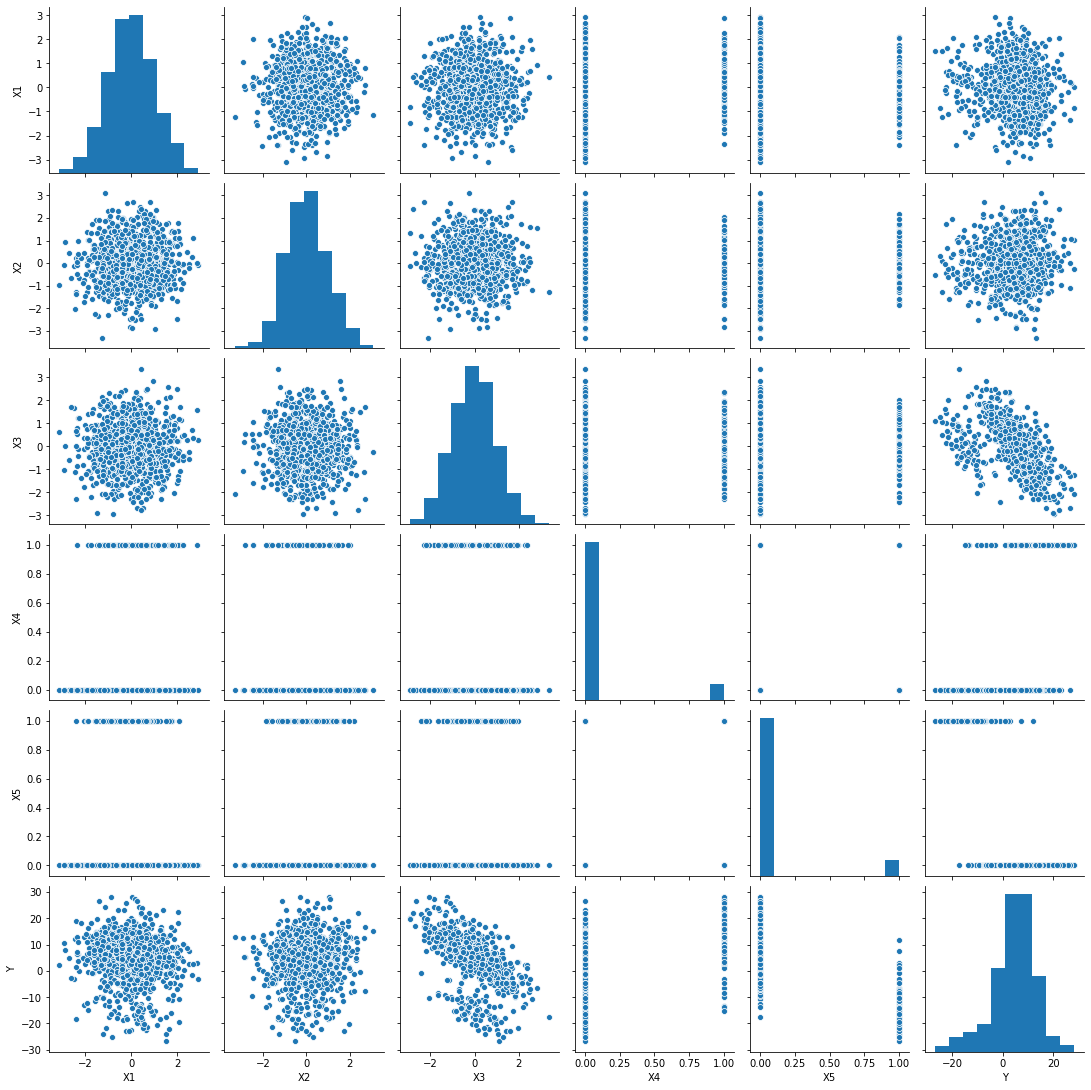

In [3]:
viz_df = X_df.copy(); viz_df["Y"] = y
sns.pairplot(viz_df)

Split the data into test/train sets and scale to standardized range

In [4]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_df, y, test_size=0.33, random_state=42)
data_scale = StandardScaler()
X_train = data_scale.fit_transform(X_train_raw)
X_test = data_scale.transform(X_test_raw)

Predict $Y$ using several methods:
1. Linear Regression
2. Decision Tree
3. Random Forest
4. Support Vector Machine

Then run some quick performance metrics on test set

In [5]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Support Vector Machine", SVR()),
    ("Random Forest", RandomForestRegressor()), 
    ("Bayesian Ridge Regression", BayesianRidge()), 
    ("Neural Network", MLPRegressor(hidden_layer_sizes=(100, 100), 
                                    tol=1e-2, max_iter=500, random_state=0))
]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    var_explained = explained_variance_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    Max_Err = max_error(y_test, y_pred)
    print("Model: {}; Variance explained: {:,.2%}; MSE: {:,.2f}; Max Error: {:,.2f}".format(
        name, var_explained, MSE, Max_Err
    ))

Model: Linear Regression; Variance explained: 86.01%; MSE: 9.45; Max Error: 9.87
Model: Decision Tree; Variance explained: 71.98%; MSE: 19.05; Max Error: 16.04
Model: Support Vector Machine; Variance explained: 79.46%; MSE: 13.90; Max Error: 12.26
Model: Random Forest; Variance explained: 82.49%; MSE: 11.84; Max Error: 10.89
Model: Bayesian Ridge Regression; Variance explained: 86.01%; MSE: 9.45; Max Error: 9.88
Model: Neural Network; Variance explained: 86.13%; MSE: 9.38; Max Error: 9.80


Random forest, neural network and variations of linear regression (OLS and ridge) all seem promising, so let's assume those become the models that we want to start probing and inspecting as we prepare for deployment. For now, we'll store them as separate variables.

In [6]:
linreg_model = models[0][1]
rf_model = models[3][1]
nn_model = models[5][1]

Assume for now that we're about to deploy the random forest model in production and want to really understand how it's working. We first consider using Shapley Additive Explanations (SHAP), a well-known technique among ML practitioners, which can be used to explain individual predictions and also aggregated across an entire suite of predictions.

Pick a random datapoint

In [7]:
random_datapoint = np.random.choice(np.arange(np.shape(X_test)[0]), 1)[0]

Look at the datapoints:
* Original feature values
* Re-scaled feature values
* Actual outcome
* Predicted outcome (by each model)

In [8]:
print("Original feature values")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Scaled feature values")
print("{}\n".format(pd.Series(X_test[random_datapoint,], index = X_df.columns)))
for name, model in models:
    y_pred = model.predict(X_test[random_datapoint,].reshape(1, -1))[0]
    print("Model: {}; Predicted Value: {:,.2f}".format(name, y_pred))
print("\nActual outcome: {:,.2f}".format(y_test.iloc[random_datapoint]))

Original feature values
X1    0.471853
X2    2.074421
X3   -1.154455
X4    0.000000
X5    0.000000
dtype: float64

Scaled feature values
X1    0.475861
X2    2.185475
X3   -1.106144
X4   -0.324978
X5   -0.327777
dtype: float64

Model: Linear Regression; Predicted Value: 12.21
Model: Decision Tree; Predicted Value: 10.87
Model: Support Vector Machine; Predicted Value: 9.38
Model: Random Forest; Predicted Value: 10.54
Model: Bayesian Ridge Regression; Predicted Value: 12.20
Model: Neural Network; Predicted Value: 11.73

Actual outcome: 12.46


### Method \#1. Partial Dependence Plots

One of the earliest approaches to explaining feature-level effects in a model is the Partial Dependence Plot ([Friedman (2001)](https://projecteuclid.org/euclid.aos/1013203451)), which looks at the predicted value of a model for each value of a given input feature after averaging out the values of the remaining features. 

This is roughly equivalent to the interpretation "holding all other features equal, how do predictions vary based on the model?"

Intuitively, this approach only works well when features are independent and there are not complicated interactions between the features and the outcome. Given our simulated data, we'll see that PDP works perfectly fine in this case, but we will see in future cases, PDP plots obscure reality.

Let's look at the impact of $X_1$ and $X_4$ on our random forest model's predictions. Based on the equation, predicted values should decrease linearly with $X_1$ and by a jump of about $10$ when activating $X_4 = 1$.

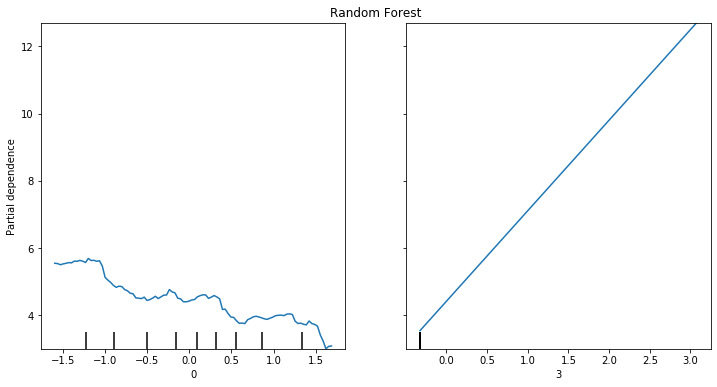

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Random Forest")
tree_disp = plot_partial_dependence(rf_model, X_test, [0, 3], ax=ax)

The trend certainly isn't perfectly linear, as we wouldn't expect a random forest to outperform a linear model when the data is truly linear. (However, in the real world, it's often difficult to plausibly assume an unknown model is linear, which is why tree ensembles, as well as neural networks, are popular.)

### Method \#2. Individual Conditional Expectations (ICE)

The next approach we consider is ICE, or Individual Conditional Expectations ([Goldstein et al (2015)](https://arxiv.org/abs/1309.6392)). 

Broadly, this is a non-averaged version of Friedman's partial dependence plots, which produces $n$ separate partial dependence plots. For each of the $n$ points in a dataset, the feature of interest is varied across its entire range while the remaining features are held constant at their original value for each sample.

In [10]:
def compute_ICE(model, data, column):
    """
    Produce ICE (Individial Conditional Expectation) estimates for each datapoint
    
    :param model: model object with a `.predict()` method
    :param data: dataset over which to compute partial dependence relationships
    :param column: (double) column index number(s) of numpy array
    :return: pd.Series of conditional expected values for each sample and each unique value of `column`
    """
    num_rows = np.shape(data)[0]
    Xc = np.sort(np.unique(data[:, column]))
    num_unique_vals = np.shape(Xc)[0]
    fixed_col_nums = np.delete(range(np.shape(data)[1]), column)
    fixed_cols = data[:, fixed_col_nums]
    fixed_cols_tiled = np.repeat(fixed_cols, num_unique_vals, axis=0)
    Xc_repeated = np.tile(Xc, num_rows)
    ICE_data = np.insert(fixed_cols_tiled, column, Xc_repeated, axis=1)
    row_indices = np.arange(num_rows)
    unique_indices = np.arange(num_unique_vals)
    return pd.Series(model.predict(ICE_data), 
        index = pd.MultiIndex.from_product([row_indices, unique_indices], names=['first', 'second'])
    ), Xc

In [11]:
def plot_ICE(ice_output, Xc, column_num):
    """
    Produce individual plots of ICE results
    
    :param ice_output: result of running `compute_ICE`
    :param Xc: List of unique variables for the column of interest
    :param column_num: column of interest
    :return: plot, printed to console
    """
    for obs, obs_df in ice_output.groupby(level=0):
        plt.plot(Xc, obs_df.values, color = "#5f6a6a")
    plt.ylabel('Partial predictions')
    plt.xlabel('Column number {:,.0f}'.format(column_num))
    plt.show()

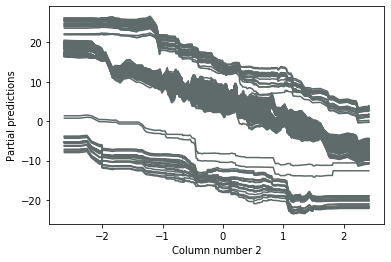

In [12]:
column = 2
ice_predictions, Xc = compute_ICE(rf_model, X_test, column)
plot_ICE(ice_predictions, Xc, column)

Well, this actually does a pretty good job of capturing the heterogeneity in our data. The giant cluster in the middle is the majority of datapoints for which both $X_4$ and $X_5$ are equal to $0$, the cluster above that is data with $X_4 = 1$ and $X_5 = 0$ (hence, predictions are higher on average because the outcome is higher on average), the bottom cluster is where $X_4 = 0$ and $X_1 = 1$ and the middle cluster represents the small number of cases in which both $X_4 = 1$ and $X_5 = 1$.

Thus, this method alerts us to the heterogeneity in the data and gives us some direction to explore which features might be driving that separation. If we re-run the ICE plot for one of the binary variables, we see that the equivalent of "activating" the variable leads to a big jump in predictions, confirming that this may be the source of the stratification.

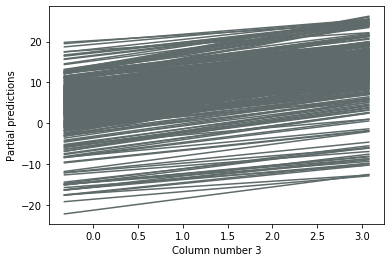

In [13]:
column = 3
ice_predictions, Xc = compute_ICE(rf_model, X_test, column)
plot_ICE(ice_predictions, Xc, column)

### Method \#3. SHAP

Next, we look at several explainability methods which fall under the broad umbrella of the Shapley value approach.

### Method \#3a. KernelSHAP

Kernel SHAP is described in [Lundberg and Lee (2017)](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) and is implemented in the `shap` Python library.

Broadly, this approach is model-agnostic. A "background" dataset is provided which is used to compute a baseline model prediction (in the case of numeric / tabular data, this would be akin to an average prediction).

Then, from this baseline of input values, features are randomly converted from baseline values to the corresponding feature value in the datapoint to be explained. After assessing the model prediction on a number of combinations of baseline feature values and target feature values, a weighted linear regression model is fit to allocate the difference between the target prediction and the baseline prediction.

Compute shapley values for the entire test set, using the training set as the background values.

In [14]:
explainer = shap.KernelExplainer(rf_model.predict, X_train)
%time shap_values = explainer.shap_values(X_test, nsamples=100, l1_reg="num_features(10)")

Using 670 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



CPU times: user 1min 8s, sys: 798 ms, total: 1min 9s
Wall time: 1min 10s


Now, we look at the shapley values for `random_datapoint` (picked above at random)

In [15]:
target_pred = rf_model.predict(X_test[random_datapoint, :].reshape(1, -1))
avg_training_pred = np.mean(rf_model.predict(X_train))
print("Difference in baseline and target prediction: {:,.2f}".format((target_pred - avg_training_pred)[0]))

Difference in baseline and target prediction: 6.35


In [16]:
print("Original model inputs:")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Shapley values for each feature")
print("{}".format(pd.Series(shap_values[random_datapoint, :], index = X_df.columns)))

Original model inputs:
X1    0.471853
X2    2.074421
X3   -1.154455
X4    0.000000
X5    0.000000
dtype: float64

Shapley values for each feature
X1   -0.287613
X2    0.239017
X3    5.435489
X4   -1.065315
X5    2.029667
dtype: float64


So the biggest contributing factor to the difference in average predictions is a low value of $X_3$, which has a coefficient of $-3$.

### Method \#3b. TreeSHAP

Tree SHAP is described in [Lundberg and Lee (2019)](https://arxiv.org/pdf/1802.03888.pdf) and is also implemented in the `shap` Python library.

Unlike Kernel SHAP, Tree SHAP is not model-agnostic and only works for various tree ensemble methods (xgboost, gradient boosted trees, random forest). The mechanics of the approach, however, are similar. 

The key difference is a computational trick that takes advantage of the recursive structure of trees to track feature subsets in polynomial time. **It is worth noting that this method requires access to the internals of a model object.**

Compute shapley values for the entire test set, using the training set as the background values.

In [17]:
explainer = shap.TreeExplainer(rf_model, X_train)
%time shap_values = explainer.shap_values(X_test, y_test)

 98%|===================| 324/330 [00:27<00:00]        

CPU times: user 26.6 s, sys: 170 ms, total: 26.7 s
Wall time: 27.1 s


Now, we look at the shapley values for `random_datapoint` (picked above at random)

In [18]:
print("Original model inputs:")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Shapley values for each feature")
print("{}".format(pd.Series(shap_values[random_datapoint, :], index = X_df.columns)))

Original model inputs:
X1    0.471853
X2    2.074421
X3   -1.154455
X4    0.000000
X5    0.000000
dtype: float64

Shapley values for each feature
X1   -0.287613
X2    0.239017
X3    5.435489
X4   -1.065315
X5    2.029667
dtype: float64


The Shapley values in this case are the same. Unfortunately, the computational speedup is delivered by using the specific trees in the model, which goes against our premise of not accessing model internals.

### Method \#4. Integrated Gradients

Integrated gradients are introduced in [Sundarajan et al (2017)](https://arxiv.org/pdf/1703.01365.pdf).

In order to explain our our prediction via the Integrated Gradient approach, we must first fit a simple deep learning model to the simulated data, which we'll do using `tf.keras` (following [this example](https://www.tensorflow.org/tutorials/keras/regression)).

In [19]:
model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[np.shape(X_train)[1]]), 
        layers.Dense(4, activation='relu'), layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse', 
              metrics=['sparse_categorical_accuracy'])

In [20]:
# Convert numpy arrays to tf datasets
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Max number of epochs
EPOCHS = 1000
# Patience parameter
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# Train model, storing metrics along the way
history = model.fit(train_dataset, epochs=EPOCHS, verbose=0, 
                    callbacks=[early_stop])

# Compute predicted values of test dataset
test_predictions = model.predict(test_dataset).flatten()

We use the integrated gradient computations provided by the `shap` library in the `GradientExplainer` class. The shap documentation explains that the approach is similar to that of the original integrated gradients library, but rather than requiring a specific starting point, it can average across a number of base values in the background dataset.

Here, we compute the shapley values for the entire test set, using the training set as background data.

In [21]:
explainer = shap.GradientExplainer(model, X_train)
%time shap_values = explainer.shap_values(X_test)

CPU times: user 3.22 s, sys: 126 ms, total: 3.35 s
Wall time: 2.77 s


In [22]:
print("Original model inputs:")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Shapley values for each feature")
print("{}".format(pd.Series(shap_values[0][random_datapoint, :], index = X_df.columns)))

Original model inputs:
X1    0.471853
X2    2.074421
X3   -1.154455
X4    0.000000
X5    0.000000
dtype: float64

Shapley values for each feature
X1   -0.423051
X2    1.023256
X3    5.856472
X4   -1.133077
X5    1.851065
dtype: float64


We see that the results are similar with a *significant* improvement in computation time. Unfortunately, this approach, too, requires access to model internals in the form of gradients.

### Method \#5. Lime

LIME is discussed in [Ribeiro et al (2016)](https://arxiv.org/pdf/1602.04938.pdf).

LIME fits a locally-weighted regression in the neighborhood of training samples around a prediction data point.

In [23]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train, feature_names=X_df.columns, class_names=['Y'], verbose=False, mode='regression'
)
exp = explainer.explain_instance(X_test[random_datapoint], rf_model.predict, num_features=5)
for item in exp.as_list():
    print(item)

('X5 <= -0.33', 20.860276875979242)
('X4 <= -0.32', -9.440002201178821)
('X3 <= -0.65', 8.963432306511232)
('X2 > 0.62', 1.1924431250416214)
('-0.03 < X1 <= 0.68', -0.1277949422672502)


Lime appears to be quick, but interpreting the feature contributions leaves something to be desired.

## (More Complex) Simulated Data Example

We have seen that while the above methods each have their advantages and disadvantages, none of them really had a breaking point given the separable linear trends in the first dataset we simulated.

So now we simulate data ($n = 1000$) with sparsity and interaction terms:

$X_1 - X_{20} \sim \textrm{Normal}(0, 1)$

$X_{21}, X_{22} ~ \sim \textrm{Bernoulli}(0.5)$

$Y = 5 - 5X_1 + 10X_2 - 10X_3 + 10X_1X_{22} - 20X_2X_{21} + \varepsilon$

$\varepsilon \sim \textrm{Normal}(0, 1)$

Thus, $X_1 - X_{20}$ are independent standard normal, $X_{21}$ and $X_{22}$ are flipped to "1" roughly half of the time, and $Y$ is only impacted by $X_1$, $X_2$, $X_3$ and interactions between $X_1$ and $X_{22}$ and $X_2$ and $X_{21}$.

In [24]:
# Set randomization seed for replicability of simulated data
np.random.seed(2020)

# Generate random data
n = 1000; sigma = 1
X_np = np.concatenate((np.random.normal(loc = 0, scale = 1, size = (n, 20)), 
                       np.random.binomial(n = 1, p = 0.5, size = (n, 2))), axis = 1)
X_df = pd.DataFrame(X_np, columns = ["X{}".format(elem) for elem in range(1, 23)])
error_term = np.random.normal(loc = 0, scale = sigma^2, size = (n))
y = (5 - 5*X_df["X1"] + 10*X_df["X2"] - 10*X_df["X3"] + 
     10*X_df["X1"]*X_df["X22"] - 20*X_df["X2"]*X_df["X21"] + error_term)

Split the data into test/train sets and scale to standardized range

In [25]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_df, y, test_size=0.33, random_state=42)
data_scale = StandardScaler()
X_train = data_scale.fit_transform(X_train_raw)
X_test = data_scale.transform(X_test_raw)

Predict $Y$ using several methods:
1. Linear Regression
2. Decision Tree
3. Random Forest
4. Support Vector Machine

Then run some quick performance metrics on test set

In [26]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Lasso", LassoCV(cv=10)),
    ("Decision Tree", DecisionTreeRegressor()),
    ("Support Vector Machine", SVR()),
    ("Random Forest", RandomForestRegressor()), 
    ("Gradient Boosting", GradientBoostingRegressor()), 
    ("Bayesian Ridge Regression", BayesianRidge()), 
    ("Neural Network", MLPRegressor(hidden_layer_sizes=(100, 100), 
                                    tol=1e-2, max_iter=500, random_state=0))
]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    var_explained = explained_variance_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    Max_Err = max_error(y_test, y_pred)
    print("Model: {}; Variance explained: {:,.2%}; MSE: {:,.2f}; Max Error: {:,.2f}".format(
        name, var_explained, MSE, Max_Err
    ))

Model: Linear Regression; Variance explained: 43.72%; MSE: 127.92; Max Error: 30.67
Model: Lasso; Variance explained: 43.43%; MSE: 128.07; Max Error: 30.01
Model: Decision Tree; Variance explained: 6.58%; MSE: 208.84; Max Error: 53.86
Model: Support Vector Machine; Variance explained: 24.12%; MSE: 172.04; Max Error: 42.66
Model: Random Forest; Variance explained: 50.35%; MSE: 111.27; Max Error: 47.38
Model: Gradient Boosting; Variance explained: 45.31%; MSE: 122.38; Max Error: 49.76
Model: Bayesian Ridge Regression; Variance explained: 43.52%; MSE: 128.48; Max Error: 31.31
Model: Neural Network; Variance explained: 90.49%; MSE: 21.28; Max Error: 15.72


With the heavy interaction terms, it seems only the MLP performs well on this data. It is likely that with hyperparameter tuning, the tree ensemble models (RF and GB) would perform well on this dataset, and certainly if we were to use xgboost or BART we could get very strong performance, but for now, we proceed as though we're ready to examine our MLP model for possible deployment.

In [27]:
mlp_model = models[7][1]

### Method \#1. Partial Dependence Plots

Let's look at the impact of $X_1$ and $X_{2}$ on our model's predictions.

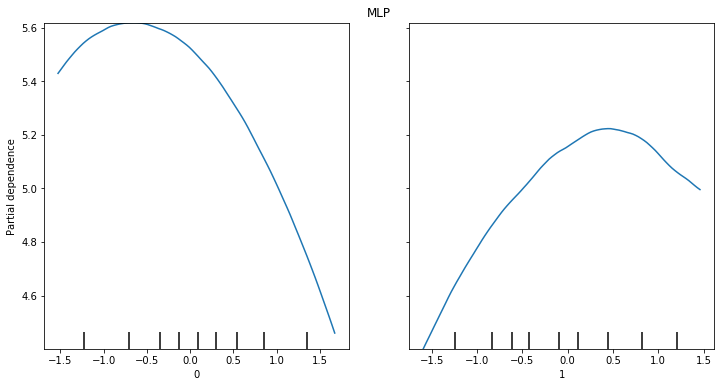

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("MLP")
tree_disp = plot_partial_dependence(mlp_model, X_test, [0, 1], ax=ax)

The shape seems awkward and likely a function of model performance at the edge of the training domain.

### Method \#2. Individual Conditional Expectations (ICE)

Next, we look at ICE plots for $X_1$ and $X_2$

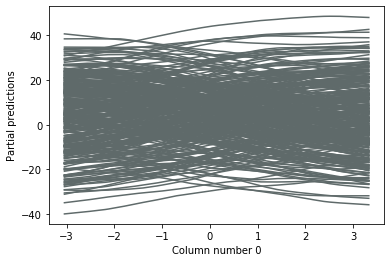

In [29]:
column = 0
ice_predictions, Xc = compute_ICE(mlp_model, X_test, column)
plot_ICE(ice_predictions, Xc, column)

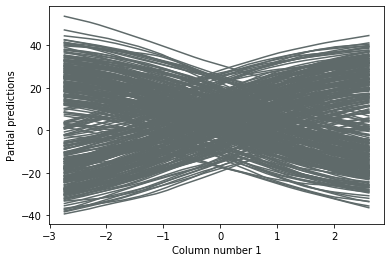

In [30]:
column = 1
ice_predictions, Xc = compute_ICE(mlp_model, X_test, column)
plot_ICE(ice_predictions, Xc, column)

This seems to be what we'd expect. About half of the time, the plot is a positive linear trend, and the other half of the time, the plot is a negative linear trend.

Let's see how the plots handle features with no impact.

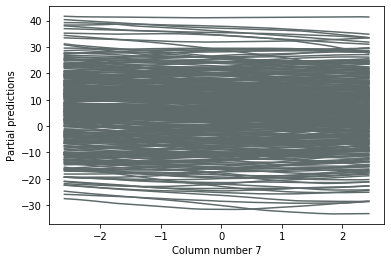

In [31]:
column = 7
ice_predictions, Xc = compute_ICE(mlp_model, X_test, column)
plot_ICE(ice_predictions, Xc, column)

Seems mostly flat, although there does appear to be a somewhat linear trend in some cases. Thus, it is possible that our model is somehow overfit.

### Method \#3. SHAP

Next, we look at several explainability methods which fall under the broad umbrella of the Shapley value approach.

### Method \#3a. KernelSHAP

Compute shapley values for the entire test set, using the training set as the background values.

In [32]:
explainer = shap.KernelExplainer(mlp_model.predict, X_train)
%time shap_values = explainer.shap_values(X_test, nsamples=100, l1_reg="num_features(22)")

Using 670 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



CPU times: user 4min 7s, sys: 6.75 s, total: 4min 13s
Wall time: 2min 37s


Now, we look at the shapley values for `random_datapoint` (picked above at random)

In [33]:
target_pred = mlp_model.predict(X_test[random_datapoint, :].reshape(1, -1))
avg_training_pred = np.mean(mlp_model.predict(X_train))
print("Difference in baseline and target prediction: {:,.2f}".format((target_pred - avg_training_pred)[0]))

Difference in baseline and target prediction: 25.38


In [34]:
print("Original model inputs:")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Shapley values for each feature")
print("{}".format(pd.Series(shap_values[random_datapoint, :], index = X_df.columns)))

Original model inputs:
X1    -0.777542
X2     0.301076
X3    -1.695481
X4     1.292947
X5    -0.140448
X6    -1.477476
X7    -1.191840
X8    -1.240998
X9    -3.317022
X10   -2.098181
X11   -0.131593
X12    0.358646
X13   -0.534224
X14    0.162460
X15   -0.205387
X16    0.444672
X17    1.098404
X18   -0.368688
X19   -0.830826
X20    0.529172
X21    0.000000
X22    1.000000
dtype: float64

Shapley values for each feature
X1     -1.114501
X2      1.900053
X3     17.984142
X4      1.627878
X5      0.660572
X6     -0.350872
X7     -0.559584
X8      1.031234
X9      2.457334
X10     1.589996
X11    -0.071557
X12    -0.376533
X13    -0.217395
X14     0.336784
X15    -0.233053
X16     0.527108
X17    -0.116419
X18     0.077919
X19     0.681896
X20    -0.088900
X21     1.812623
X22    -2.179136
dtype: float64


Here, the largest contributing factor is an $X_3$ value which is almost 2 standard deviations from 0.

But we can also now observe that our model hasn't captured the sparsity. This makes sense given we didn't enforce any sort of regularization on the MLP at training time, so it is just a large flexible curve-approximator.

### Method \#4. Integrated Gradients

Integrated gradients are introduced in [Sundarajan et al (2017)](https://arxiv.org/pdf/1703.01365.pdf).

In order to explain our our prediction via the Integrated Gradient approach, we must first fit a simple deep learning model to the simulated data, which we'll do using `tf.keras` (following [this example](https://www.tensorflow.org/tutorials/keras/regression)).

In [35]:
model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[np.shape(X_train)[1]]), 
        layers.Dense(64, activation='relu'), layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse', 
              metrics=['sparse_categorical_accuracy'])

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                1472      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,697
Trainable params: 5,697
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Convert numpy arrays to tf datasets
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Max number of epochs
EPOCHS = 1000
# Patience parameter
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
# Train model, storing metrics along the way
history = model.fit(train_dataset, epochs=EPOCHS, verbose=0, 
                    callbacks=[early_stop])

In [38]:
# Compute predicted values of test dataset
test_predictions = model.predict(test_dataset).flatten()

We use the integrated gradient computations provided by the `shap` library in the `GradientExplainer` class. The shap documentation explains that the approach is similar to that of the original integrated gradients library, but rather than requiring a specific starting point, it can average across a number of base values in the background dataset.

Here, we compute the shapley values for the entire test set, using the training set as background data.

In [39]:
explainer = shap.GradientExplainer(model, X_train)
%time shap_values = explainer.shap_values(X_test)

CPU times: user 7.02 s, sys: 7.43 s, total: 14.4 s
Wall time: 4.57 s


In [40]:
print("Original model inputs:")
print("{}\n".format(pd.Series(X_test_raw.to_numpy()[random_datapoint,], index = X_df.columns)))
print("Shapley values for each feature")
print("{}".format(pd.Series(shap_values[0][random_datapoint, :], index = X_df.columns)))

Original model inputs:
X1    -0.777542
X2     0.301076
X3    -1.695481
X4     1.292947
X5    -0.140448
X6    -1.477476
X7    -1.191840
X8    -1.240998
X9    -3.317022
X10   -2.098181
X11   -0.131593
X12    0.358646
X13   -0.534224
X14    0.162460
X15   -0.205387
X16    0.444672
X17    1.098404
X18   -0.368688
X19   -0.830826
X20    0.529172
X21    0.000000
X22    1.000000
dtype: float64

Shapley values for each feature
X1     -2.071980
X2      4.581549
X3     16.796095
X4      0.728949
X5      0.268158
X6     -0.572978
X7     -1.146450
X8      0.841518
X9      1.618542
X10     1.171889
X11    -0.129602
X12    -0.015569
X13    -0.237797
X14    -0.032329
X15    -0.154306
X16     0.148459
X17    -0.468222
X18    -0.030634
X19     0.047972
X20     0.005774
X21     3.522198
X22    -2.346780
dtype: float64


We see that the results are similar to those of the kernel explainer with a *significant* improvement in computation time.

### Method \#5. Lime

In [41]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train, feature_names=X_df.columns, class_names=['Y'], verbose=False, mode='regression'
)
exp = explainer.explain_instance(X_test[random_datapoint], mlp_model.predict, num_features=5)
for item in exp.as_list():
    print(item)

('X3 <= -0.70', 18.64024374677855)
('X1 <= -0.64', -4.420946616532169)
('0.02 < X2 <= 0.58', -1.6946385536479265)
('-0.03 < X14 <= 0.65', -1.01403469366892)
('X21 <= -0.95', -0.7448166898338292)


While the interpretation is still a bit tricky, this approach actually seems to have been quick and also captured the important features of the model.

# References

Friedman, Jerome H. "Greedy function approximation: A gradient boosting machine". Ann. Statist. 29 (2001), no. 5, 1189--1232. doi:10.1214/aos/1013203451. https://projecteuclid.org/euclid.aos/1013203451

Goldstein, A., Kapelner, A., Bleich, J., Pitkin, E. "Peeking inside the black box: Visualizing statistical learning with plots of individual conditional expectation", 2015. Journal of Computational and Graphical Statistics 24(1), 44 - 65. https://arxiv.org/abs/1309.6392.

Google, Inc. "AI Explainability Whitepaper", 2019. https://storage.googleapis.com/cloud-ai-whitepapers/AI%20Explainability%20Whitepaper.pdf.

Lundberg, S.M., Lee, S. "A Unified Approach to Interpreting Model Predictions", 2017. Advances in Neural Information Processing Systems 30, 4765--4774. http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf.

Lundberg, S.M., Lee, S. "Consistent individualized feature attribution for tree ensembles", 2018. arXiv preprint arXiv:1802.03888. https://arxiv.org/pdf/1802.03888.pdf.

Molnar, Christoph. "Interpretable machine learning. A Guide for Making Black Box Models Explainable", 2019. https://christophm.github.io/interpretable-ml-book/.

Ribeiro, M.T., Singh, S., Guestrin, C. "'Why should I trust you?' Explaining the predictions of any classifier", 2016. Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining, 1135--1144. https://arxiv.org/pdf/1602.04938.pdf

Sundararajan, M., Taly, A., Yan, Q. "Axiomatic attribution for deep networks", 2017. Proceedings of the 34th International Conference on Machine Learning-Volume 70 3319--3328. https://arxiv.org/pdf/1703.01365.pdf.

Taly, Ankur. "Integrated Gradient Slides", 2018. https://github.com/ankurtaly/Integrated-Gradients/blob/master/icml_slides.pdf.